In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import zscore, pearsonr, spearmanr

In [23]:
Fastq_samples = pd.read_csv("../code/config/samples.tsv", sep='\t', comment='#')
igsr_samples = pd.read_csv('../data/igsr_samples.tsv.gz', sep='\t', index_col=0)

polyA_samples = Fastq_samples.loc[Fastq_samples.Phenotype == 'Expression.Splicing'].IndID
YRI_samples = igsr_samples.loc[igsr_samples['Population code'] == 'YRI'].index

temp = '../code/QTLs/QTLTools/{Phenotype}/OnlyFirstRepsBasicUnstandardized.qqnorm.bed.gz'
temp_ = '../code/QTLs/QTLTools/{Phenotype}/OnlyFirstRepsUnstandardized.qqnorm.bed.gz'


polyA = pd.read_csv(temp.format(Phenotype = 'Expression.Splicing'), sep='\t', index_col=3)
chRNA = pd.read_csv(temp.format(Phenotype = 'chRNA.Expression.Splicing'), sep='\t', index_col=3)
ml30 = pd.read_csv(temp.format(Phenotype = 'MetabolicLabelled.30min'), sep='\t', index_col=3)
ml60 = pd.read_csv(temp.format(Phenotype = 'MetabolicLabelled.60min'), sep='\t', index_col=3)

h3k36me3 = pd.read_csv("../code/QTLs/QTLTools/H3K36ME3/OnlyFirstRepsUnstandardized.qqnorm.bed.gz", 
                       sep='\t', index_col=3)


temp = '../code/QTLs/QTLTools/{Phenotype}/OnlyFirstRepsUnstandardized_AtTSS.qqnorm.bed.gz'
h3k27ac = pd.read_csv(temp.format(Phenotype = 'H3K27AC'), sep='\t', index_col=3)
h3k4me3 = pd.read_csv(temp.format(Phenotype = 'H3K4ME3'), sep='\t', index_col=3)
h3k4me1 = pd.read_csv(temp.format(Phenotype = 'H3K4ME1'), sep='\t', index_col=3)


In [24]:
shared_samples = h3k36me3.columns.intersection(YRI_samples).intersection(h3k4me3.columns).intersection(
    h3k27ac.columns).intersection(polyA.columns).intersection(chRNA.columns).intersection(
    ml30.columns).intersection(h3k36me3.columns)

In [25]:
expressed_genes = polyA.loc[polyA[polyA.columns[5:]].median(axis=1) > -2].index

In [26]:
all_RNAs = pd.Index(expressed_genes).intersection(ml30.index).intersection(ml60.index).intersection(h3k36me3.index) #+ lncRNA + snoRNA + list(eRNA) + list(cheRNA)# + introns

polyA_samples = polyA.columns.intersection(YRI_samples)
polyA_logRPKM = polyA.loc[all_RNAs, shared_samples]
polyA_logRPKM.columns = ['polyA.' + x for x in shared_samples]

chRNA_samples = chRNA.columns.intersection(YRI_samples)
chRNA_logRPKM = chRNA.loc[all_RNAs, shared_samples]
chRNA_logRPKM.columns = ['chRNA.' + x for x in shared_samples]

ml60_samples = ml60.columns.intersection(YRI_samples)
ml60_logRPKM = ml60.loc[all_RNAs, shared_samples]
ml60_logRPKM.columns = ['ml60.' + x for x in shared_samples]

ml30_samples = ml30.columns.intersection(YRI_samples)
ml30_logRPKM = ml30.loc[all_RNAs, shared_samples]
ml30_logRPKM.columns = ['ml30.' + x for x in shared_samples]

# ml60_samples = ml60.columns.intersection(YRI_samples)
# h3k4me3_logRPKM = h3k4me3.loc[all_RNAs, shared_samples]
# h3k4me3_logRPKM.columns = ['h3k4me3.' + x for x in shared_samples]

h3k36me3_samples = h3k36me3.columns.intersection(YRI_samples)
h3k36me3_logRPKM = h3k36me3.loc[all_RNAs, shared_samples]
h3k36me3_logRPKM.columns = ['h3k36me3.' + x for x in shared_samples]




# h3k27ac_logRPKM = h3k27ac.loc[all_RNAs, shared_samples]
# h3k27ac_logRPKM.columns = ['h3k27ac.' + x for x in shared_samples]


In [27]:
H3K4ME3_TSS = pd.read_csv('../code/featureCounts/H3K4ME3/Counts.txt',
                                 sep='\t', skiprows = 1)
H3K4ME3_names = [x.split('ME3/')[1].split('.1')[0] for x in H3K4ME3_TSS.columns if ('Alignments' in x)]

H3K4ME3 = pd.read_csv('../code/QTLs/QTLTools/H3K4ME3/CountsPeaksAtTSS.bed.gz',#'../../H3K4ME3.TSS.PeakCounts.bed.gz', 
                      sep='\t',
                     names = ['chrom', 'start', 'end', 'transcript_id', 'ensembl_id', 'strand',
                             'gene_id', 'chrom_', 'start_', 'end_', 'peak_id', 'peak_len',
                             'strand_'] + H3K4ME3_names + ['overlap_len'])
                     
H3K4ME3_samples = H3K4ME3.columns.intersection(shared_samples)
H3K4ME3 = H3K4ME3.groupby(['ensembl_id', 'peak_id']).max()
H3K4ME3_counts = H3K4ME3.groupby('ensembl_id')[H3K4ME3_samples].sum()
h3k4me3_CPM = H3K4ME3_counts.divide(H3K4ME3_counts.sum(axis=0), axis=1)*1e6

h3k4me3_CPM = h3k4me3_CPM.loc[h3k4me3_CPM.median(axis=1) > 0]
h3k4me3_logRPKM = np.log(h3k4me3_CPM)
h3k4me3_logRPKM.columns = ['h3k4me3.' + x for x in h3k4me3_logRPKM.columns]


In [28]:
H3K27AC_TSS = pd.read_csv('../code/featureCounts/H3K27AC/Counts.txt',
                                 sep='\t', skiprows = 1)
H3K27AC_names = [x.split('27AC/')[1].split('.1')[0] for x in H3K27AC_TSS.columns if ('Alignments' in x)]

H3K27AC = pd.read_csv('../code/QTLs/QTLTools/H3K27AC/CountsPeaksAtTSS.bed.gz',#'../../H3K27AC.TSS.PeakCounts.bed.gz', 
                      sep='\t',
                     names = ['chrom', 'start', 'end', 'transcript_id', 'ensembl_id', 'strand',
                             'gene_id', 'chrom_', 'start_', 'end_', 'peak_id', 'peak_len',
                             'strand_'] + H3K27AC_names + ['overlap_len'])
                     
H3K27AC_samples = H3K27AC.columns.intersection(shared_samples)
H3K27AC = H3K27AC.groupby(['ensembl_id', 'peak_id']).max()
H3K27AC_counts = H3K27AC.groupby('ensembl_id')[H3K27AC_samples].sum()
h3k27ac_CPM = H3K27AC_counts.divide(H3K27AC_counts.sum(axis=0), axis=1)*1e6

h3k27ac_CPM = h3k27ac_CPM.loc[h3k27ac_CPM.median(axis=1) > 0]
h3k27ac_logRPKM = np.log(h3k27ac_CPM)
h3k27ac_logRPKM.columns = ['h3k27ac.' + x for x in h3k27ac_logRPKM.columns]


In [53]:
all_phenotypes = pd.concat([h3k27ac_logRPKM,
                            h3k4me3_logRPKM, 
                            h3k36me3_logRPKM, 
                            chRNA_logRPKM, 
                            ml30_logRPKM, ml60_logRPKM, polyA_logRPKM], axis=1)

pheno_corr = all_phenotypes.corr(method='spearman')

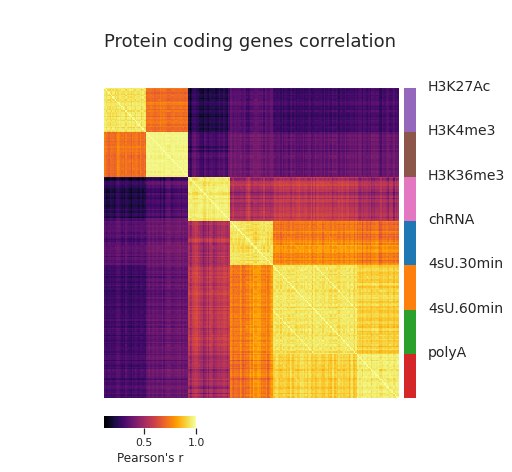

In [54]:
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})


col_list = plt.cm.tab10(range(10))
colores = [col_list[4]]*len(h3k27ac_logRPKM.columns)
colores += [col_list[5]]*len(h3k4me3_logRPKM.columns)
colores += [col_list[6]]*len(h3k36me3_logRPKM.columns)
colores += [col_list[0]]*len(chRNA_logRPKM.columns)
colores += [col_list[1]]*len(ml30_logRPKM.columns)
colores += [col_list[2]]*len(ml60_logRPKM.columns)
colores += [col_list[3]]*len(polyA_logRPKM.columns)



g = sns.clustermap(pheno_corr, row_colors = colores, row_cluster=False, col_cluster=False,
              cmap='inferno', cbar_kws={'label': "Pearson's r", "orientation": "horizontal"},
                  figsize=(7.5, 7.5))


g.ax_heatmap.set_xticklabels([])
g.ax_heatmap.set_yticklabels([])
g.ax_heatmap.tick_params(right=False, bottom=False)

n = len(pheno_corr)
m = len(h3k27ac_logRPKM.columns)
g.ax_heatmap.text(n*1.1, m-30, 'H3K27Ac', size=14, )
m += len(h3k4me3_logRPKM.columns)
g.ax_heatmap.text(n*1.1, m-30, 'H3K4me3', size=14, )
m += len(h3k36me3_logRPKM.columns)
g.ax_heatmap.text(n*1.1, m-30, 'H3K36me3', size=14,)
m += len(chRNA_logRPKM.columns)
g.ax_heatmap.text(n*1.1, m-30, 'chRNA', size=14, )
m += len(ml30_logRPKM.columns)
g.ax_heatmap.text(n*1.1, m-30, '4sU.30min', size=14,)
m += len(ml60_logRPKM.columns)
g.ax_heatmap.text(n*1.1, m-30, '4sU.60min', size=14, )
m += len(polyA_logRPKM.columns)
g.ax_heatmap.text(n*1.1, m-30, 'polyA', size=14, )

box_heatmap = g.ax_heatmap.get_position()
box_cbar = g.ax_cbar.get_position()

g.ax_cbar.set_position([box_heatmap.min[0], box_heatmap.max[1]-0.63, box_cbar.max[0]+0.1, 
                        box_cbar.max[0]/3])

box = g.ax_row_colors.get_position()

g.ax_heatmap.text(0, -30, 'Protein coding genes correlation', size=18)

# g.ax_col_colors.set_position([box_heatmap.max[0], box.y0, box.width*1.5, box.height])
g.ax_row_colors.set_position([box_heatmap.max[0]+0.01, box_heatmap.min[1], box.width, box.height])


plt.show()
# plt.savefig('../plots/correlation.heatmap.png', dpi=300, bbox_inches='tight',)

In [39]:
h3k36me3_last3k = pd.read_csv(
    "../code/QTLs/QTLTools/H3K36ME3/OnlyFirstRepsUnstandardized.Last3K.qqnorm.bed.gz", 
    sep='\t', index_col=3)

h3k36me3_encode = pd.read_csv(
    "../code/QTLs/QTLTools/H3K36ME3/OnlyFirstRepsUnstandardized.Encode.qqnorm.bed.gz", 
    sep='\t', index_col=3)


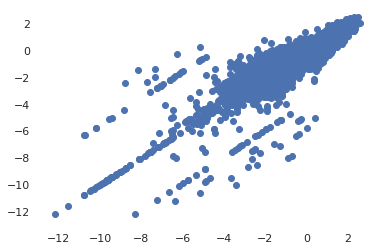

In [40]:
plt.scatter(h3k36me3_encode['GM12878_2.2'], h3k36me3_encode['GM12878_2.1'])

In [52]:
spearmanr(h3k36me3_encode['GM12878.2'], 
            h3k36me3.NA19108)

SpearmanrResult(correlation=0.8046105112313247, pvalue=0.0)

In [45]:
h3k36me3_encode

,#Chr,start,end,gid,strand,GM12878.1,GM12878_2.1,GM06990.1,GM12878.2,GM12878_2.2,GM06990.2
pid,,,,,,,,,,,
ENSG00000188976.11,chr1,944202,959309,.,-,2.126128,0.926834,2.038736,2.239487,1.140227,1.910036
ENSG00000187961.14,chr1,960583,965719,.,+,0.515083,-0.264072,0.411221,1.282358,-0.157573,0.515366
ENSG00000187583.11,chr1,966481,975865,.,+,-0.675735,-2.709439,-1.521285,-0.171376,-3.014394,-1.609205
ENSG00000188290.11,chr1,998961,1000172,.,-,-1.270385,-6.475301,-3.392151,0.030696,-6.475301,-3.299733
ENSG00000187608.10,chr1,1001137,1014540,.,+,-0.688499,-1.467879,-1.107687,-0.398507,-1.541412,-0.847139
...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000148399.13,chr9,137554443,137578925,.,-,1.192065,0.751820,1.203340,1.289375,0.895438,1.176943
ENSG00000165724.6,chr9,137582080,137590512,.,-,1.730190,0.782988,1.797620,1.662051,1.211395,1.743293
ENSG00000197070.14,chr9,137605684,137615360,.,+,0.822180,-0.228965,0.897184,0.825024,0.069284,1.163097


In [49]:
h3k36me3#.NA19152

,#Chr,start,end,gid,strand,NA19152,NA19153,NA19171,NA19200,NA19160,...,NA18910,NA18876,NA19108,NA19141,NA19098,NA19213,NA19121,NA19107,NA19118,NA19143
pid,,,,,,,,,,,,,,,,,,,,,
ENSG00000188976.11,chr1,944202,959309,.,-,3.102807,3.130335,3.048530,2.815559,3.005215,...,3.211143,3.169350,3.231720,2.964541,2.413697,2.468702,2.673368,2.503159,2.803639,2.587741
ENSG00000187961.14,chr1,960583,965719,.,+,2.079896,2.353003,2.180901,2.279604,1.974905,...,2.282470,2.423709,2.218421,2.239688,1.824795,2.050294,1.839614,1.752412,1.872263,1.594607
ENSG00000187583.11,chr1,966481,975865,.,+,1.005383,1.396487,0.977278,1.071533,1.306466,...,1.086519,1.019022,0.814079,1.067497,0.775765,0.684264,0.272069,0.778311,0.619769,0.782739
ENSG00000188290.11,chr1,998961,1000172,.,-,0.159292,0.258989,-0.026602,-0.437931,0.348012,...,0.546735,0.169761,0.933292,0.557896,0.530042,-0.539542,-1.478307,0.383508,-0.009790,0.875773
ENSG00000187608.10,chr1,1001137,1014540,.,+,0.466021,0.840878,0.799770,0.257228,0.591067,...,1.252970,1.042018,0.915235,0.437519,1.217043,1.035125,0.862259,1.060218,0.731696,0.364175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000148399.13,chr9,137554443,137578925,.,-,2.247302,2.123165,2.372588,1.965411,2.003810,...,2.151026,2.233515,2.184975,2.195796,2.374257,2.526110,2.621321,2.146379,2.268545,2.226151
ENSG00000165724.6,chr9,137582080,137590512,.,-,2.584137,2.696458,2.780805,2.588105,2.416693,...,2.392559,2.598905,2.633382,2.538339,2.198526,2.255660,2.297713,2.252003,2.311274,2.122256
ENSG00000197070.14,chr9,137605684,137615360,.,+,2.466654,2.777202,2.548093,2.389569,2.426623,...,2.506452,2.729658,2.682484,2.319251,2.226459,2.350612,2.157466,1.858375,2.212257,2.054399


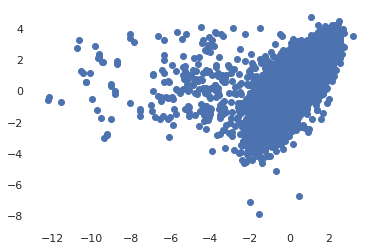

In [55]:
plt.scatter(h3k36me3_encode['GM12878.2'], 
            h3k36me3.NA19108)

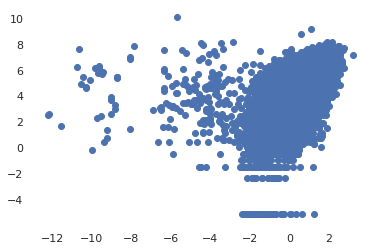

In [60]:
plt.scatter(h3k36me3_encode['GM12878.2'].loc[h3k36me3_last3k.index], 
            h3k36me3_last3k.NA19108)

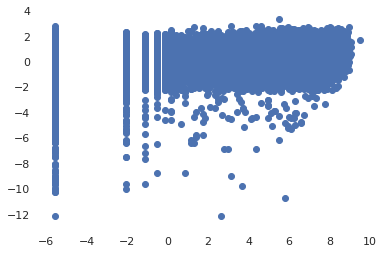

In [64]:
plt.scatter(h3k4me3['NA19092'], h3k36me3_encode['GM12878.1'])

In [95]:
all_h3k36 = pd.concat([h3k27ac_logRPKM.iloc[:,6:10],
                       h3k4me3_logRPKM.iloc[:,6:10],
                       h3k36me3[shared_samples].iloc[:,6:10], 
                       h3k36me3_encode[['GM12878.1', 'GM12878.2',
                                        'GM06990.1', 'GM06990.2']],
                       chRNA_logRPKM.iloc[:,6:10],
                       ml30_logRPKM.iloc[:,6:10],
                       ml60_logRPKM.iloc[:,6:10],
                       polyA_logRPKM.iloc[:,6:10],
                      ], axis=1)

In [92]:
small_size_df = 

NameError: name 'small_size' is not defined

In [97]:
pheno_corr = all_h3k36.corr(method='spearman')

In [101]:
pheno_corr.shape

(32, 32)

In [100]:
colores

[array([0.58039216, 0.40392157, 0.74117647, 1.        ]),
 array([0.58039216, 0.40392157, 0.74117647, 1.        ]),
 array([0.58039216, 0.40392157, 0.74117647, 1.        ]),
 array([0.58039216, 0.40392157, 0.74117647, 1.        ]),
 array([0.54901961, 0.3372549 , 0.29411765, 1.        ]),
 array([0.54901961, 0.3372549 , 0.29411765, 1.        ]),
 array([0.54901961, 0.3372549 , 0.29411765, 1.        ]),
 array([0.54901961, 0.3372549 , 0.29411765, 1.        ]),
 array([0.89019608, 0.46666667, 0.76078431, 1.        ]),
 array([0.89019608, 0.46666667, 0.76078431, 1.        ]),
 array([0.89019608, 0.46666667, 0.76078431, 1.        ]),
 array([0.89019608, 0.46666667, 0.76078431, 1.        ]),
 array([0.12156863, 0.46666667, 0.70588235, 1.        ]),
 array([0.12156863, 0.46666667, 0.70588235, 1.        ]),
 array([0.12156863, 0.46666667, 0.70588235, 1.        ]),
 array([0.12156863, 0.46666667, 0.70588235, 1.        ]),
 array([1.        , 0.49803922, 0.05490196, 1.        ]),
 array([1.    

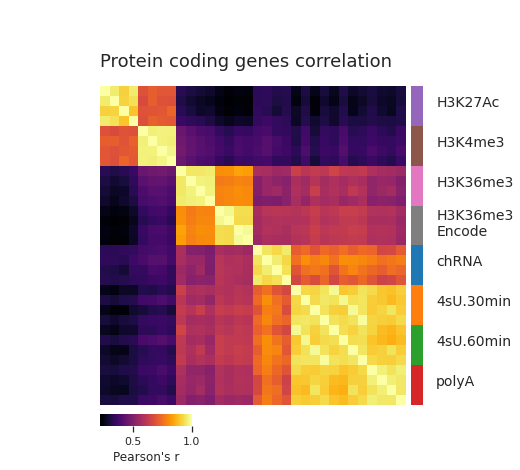

In [107]:
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})


col_list = plt.cm.tab10(range(10))
colores = [col_list[4]]*4
colores += [col_list[5]]*4
colores += [col_list[6]]*4
colores += [col_list[7]]*4
colores += [col_list[0]]*4
colores += [col_list[1]]*4
colores += [col_list[2]]*4
colores += [col_list[3]]*4



g = sns.clustermap(pheno_corr, row_colors = colores, row_cluster=False, col_cluster=False,
              cmap='inferno', cbar_kws={'label': "Pearson's r", "orientation": "horizontal"},
                  figsize=(7.5, 7.5))


g.ax_heatmap.set_xticklabels([])
g.ax_heatmap.set_yticklabels([])
g.ax_heatmap.tick_params(right=False, bottom=False)

n = len(pheno_corr)
m = 4
g.ax_heatmap.text(n*1.1, m-2, 'H3K27Ac', size=14, )
m += 4
g.ax_heatmap.text(n*1.1, m-2, 'H3K4me3', size=14, )
m += 4
g.ax_heatmap.text(n*1.1, m-2, 'H3K36me3', size=14,)
m += 4
g.ax_heatmap.text(n*1.1, m-1, 'H3K36me3\nEncode', size=14,)
m += 4
g.ax_heatmap.text(n*1.1, m-2, 'chRNA', size=14, )
m += 4
g.ax_heatmap.text(n*1.1, m-2, '4sU.30min', size=14,)
m += 4
g.ax_heatmap.text(n*1.1, m-2, '4sU.60min', size=14, )
m += 4
g.ax_heatmap.text(n*1.1, m-2, 'polyA', size=14, )

box_heatmap = g.ax_heatmap.get_position()
box_cbar = g.ax_cbar.get_position()

g.ax_cbar.set_position([box_heatmap.min[0], box_heatmap.max[1]-0.63, box_cbar.max[0]+0.1, 
                        box_cbar.max[0]/3])

box = g.ax_row_colors.get_position()

g.ax_heatmap.text(0, -2, 'Protein coding genes correlation', size=18)

# g.ax_col_colors.set_position([box_heatmap.max[0], box.y0, box.width*1.5, box.height])
g.ax_row_colors.set_position([box_heatmap.max[0]+0.01, box_heatmap.min[1], box.width, box.height])


plt.show()
# plt.savefig('../plots/correlation.heatmap.png', dpi=300, bbox_inches='tight',)

In [99]:
pheno_corr

,h3k27ac.NA19102,h3k27ac.NA19190,h3k27ac.NA18520,h3k27ac.NA18499,h3k4me3.NA18498,h3k4me3.NA19190,h3k4me3.NA19147,h3k4me3.NA18520,NA19131,NA19130,...,ml30.NA18519,ml30.NA18511,ml60.NA19131,ml60.NA19130,ml60.NA18519,ml60.NA18511,polyA.NA19131,polyA.NA19130,polyA.NA18519,polyA.NA18511
h3k27ac.NA19102,1.000000,0.954466,0.912369,0.955303,0.688549,0.717402,0.700565,0.699495,0.334257,0.312307,...,0.255806,0.300836,0.266214,0.316137,0.277545,0.291170,0.305053,0.287886,0.280236,0.305811
h3k27ac.NA19190,0.954466,1.000000,0.915932,0.937684,0.672023,0.718003,0.687719,0.683867,0.315961,0.290148,...,0.233917,0.284972,0.252196,0.305294,0.257578,0.274383,0.300967,0.277576,0.267381,0.300320
h3k27ac.NA18520,0.912369,0.915932,1.000000,0.892088,0.692515,0.693014,0.700713,0.730320,0.336384,0.305005,...,0.235410,0.301253,0.283655,0.324338,0.256771,0.291285,0.319323,0.285686,0.264381,0.318263
h3k27ac.NA18499,0.955303,0.937684,0.892088,1.000000,0.686079,0.722191,0.708206,0.703024,0.358673,0.344589,...,0.286741,0.315449,0.282183,0.333534,0.307943,0.307039,0.323157,0.314337,0.308963,0.320828
h3k4me3.NA18498,0.688549,0.672023,0.692515,0.686079,1.000000,0.964191,0.966571,0.967034,0.449840,0.420609,...,0.299164,0.351524,0.343391,0.390772,0.328381,0.341729,0.363976,0.339076,0.323434,0.363397
h3k4me3.NA19190,0.717402,0.718003,0.693014,0.722191,0.964191,1.000000,0.969439,0.962439,0.461743,0.436665,...,0.324327,0.360051,0.341704,0.396593,0.353439,0.351189,0.372245,0.356720,0.349848,0.371292
h3k4me3.NA19147,0.700565,0.687719,0.700713,0.708206,0.966571,0.969439,1.000000,0.972683,0.469307,0.438320,...,0.328497,0.366838,0.359518,0.412224,0.357011,0.358196,0.391828,0.370092,0.353812,0.387833
h3k4me3.NA18520,0.699495,0.683867,0.730320,0.703024,0.967034,0.962439,0.972683,1.000000,0.453848,0.423909,...,0.298889,0.349905,0.343395,0.386437,0.326271,0.340702,0.366125,0.340993,0.323214,0.363887
NA19131,0.334257,0.315961,0.336384,0.358673,0.449840,0.461743,0.469307,0.453848,1.000000,0.949641,...,0.626481,0.614284,0.653198,0.617368,0.614086,0.624988,0.583927,0.568188,0.560266,0.549600
NA19130,0.312307,0.290148,0.305005,0.344589,0.420609,0.436665,0.438320,0.423909,0.949641,1.000000,...,0.600126,0.563885,0.584863,0.565086,0.584413,0.577111,0.526862,0.538860,0.537478,0.503605
